In [1]:
import bootstrap_testing as bt
import numpy as np
from scipy import stats
import pingouin as pg
import os
import pandas as pd

In [2]:
# Lets use data from FIN 2335 test: FLAG 269
query = '''
with precondition as (
    SELECT
    	DISTINCT(t.session_id) as session_id
    FROM
    	HEYCAR.TRACKING t
    JOIN
        HEYCAR.SESSION s on t.session_id = s.session_id
    WHERE
    	t.event_name = 'pages'
        AND t.page_type in ('CLP')
        AND t.event_day  >= '2022-09-25'
        AND t.platform_id = 0
        AND s.device_type in ('mobile')
        AND (s.is_bot is null OR s.is_bot = 0)
        --AND s.has_tracking_consent = 1
        AND s.country_code = 'de'
        AND t.country_code = 'de'
), sessions as (
	SELECT
		t.session_id,
		s.session_day,
		u.experiment_group_name as test_group
    FROM
    	HEYCAR.TRACKING t
    JOIN
        HEYCAR.SESSION s on t.session_id = s.session_id
    JOIN
        HEYCAR.USER_EXPERIMENT_SNAPSHOT u on (u.event_day = s.session_day
                                            and u.user_id = s.user_id)
    WHERE
    	t.event_day  >= '2022-10-06'
        AND s.session_day  >= '2022-10-06'
        AND u.experiment_id = '269'
        AND t.platform_id = 0
        AND s.device_type in ('mobile')
        AND (s.is_bot is null OR s.is_bot = 0)
        --AND s.has_tracking_consent = 1
        AND t.country_code = 'de'
        AND s.country_code = 'de'
        AND t.session_id in (SELECT session_id FROM precondition)
    GROUP BY
    	1, 2, 3
), leads as (

	SELECT
		sl.session_id,
		sl.session_day,
		count(distinct l.lead_id) as leads
	FROM
		HEYCAR.SESSION_LEAD_LOOKUP sl
    JOIN
        HEYCAR.LEAD l on sl.lead_id = l.lead_id
	WHERE
        sl.session_day >= '2022-10-06'
        AND sl.country_code = 'de' 
        AND l.IS_QUALITY_LEAD = 1
    GROUP BY
        1, 2

)

SELECT
    s.session_id,
	s.session_day,
	s.test_group,
	l.leads
FROM
	sessions s
LEFT JOIN
	leads l on s.session_id = l.session_id
WHERE
    s.session_day <= '2022-10-20'
'''

In [3]:
#df = bt.get_data(query=query)   #query data from DWH & save to Downloads folder
df = bt.load_data(os.path.join(os.environ['HOME'], 'Downloads/bootstrap_demo.csv'))  #load data from Downloads folder

In [4]:
df.head(10)

,Unnamed: 0,session_id,session_day,test_group,leads
0,0,ajs-7041aea2b6320e2b62a4daa9d2f22fa1,2022-10-11,show_control,1.0
1,1,ajs-bf95121730b89deb72ce823d8a791f42,2022-10-20,show_control,3.0
2,2,ajs-08276465b54d8352a72cacbaa79d8092,2022-10-17,show_control,2.0
3,3,ajs-ce47d36e0c92e91e2ae44207387b5e05,2022-10-16,show_variant,1.0
4,4,ajs-62e0108bd1bc478c4539a7b85e77e682,2022-10-19,show_control,2.0
5,5,ajs-1ff73606f84b2c723a19afe5544c8204,2022-10-12,show_variant,1.0
6,6,ajs-05e2711b7f440432c7379304ef52fae5,2022-10-10,show_control,1.0
7,7,ajs-8e273c51bfce6364978cc1bfa95e3c30,2022-10-10,show_control,1.0
8,8,ajs-2cd7d9c38128e2076ca1e2a9a8dc30fd,2022-10-15,show_variant,1.0
9,9,ajs-8b06174475f94c5d4e43815bb1ad626d,2022-10-17,show_variant,1.0


In [5]:
control = df[df.test_group=='show_control']
variant = df[df.test_group=='show_variant']
print((len(control), len(variant)))

(124293, 117275)


In [23]:
control_metric = bt.bootstrap(control, size=min(len(control),len(variant)) , iter=1000)
variant_metric = bt.bootstrap(variant, size=min(len(control),len(variant)) , iter=1000)

control lower, mean, upper bound:  0.005392536707724194 0.005413361756555106 0.005434186805386018
variant lower, mean, upper bound:  0.005050131062291471 0.005069827328927734 0.005089523595563997


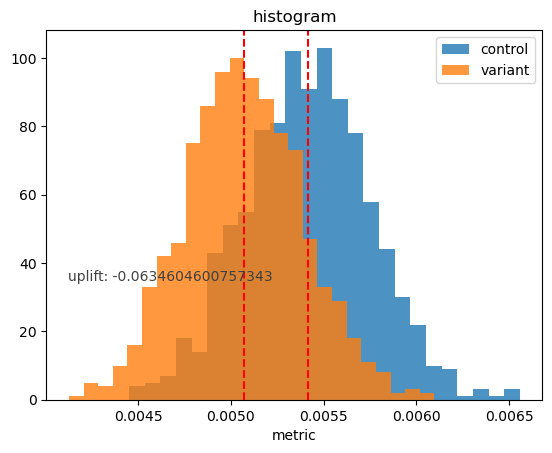

In [24]:
bt.plot_histogram(control=control_metric,
                  variant=variant_metric,
                  bins=25
                )

In [21]:
#pd.DataFrame(control_metric).boxplot()

In [9]:
stats.norm.interval(alpha=0.95,
                    loc=np.mean(control_metric),
                    scale=stats.sem(control_metric)
                    )

(0.0053700466611733624, 0.005471553338826637)

In [22]:
# T-Test from scipy
t_score, pvalue = stats.ttest_ind(control_metric, variant_metric)
t_score, pvalue, pvalue<0.05

(10.933937353121824, 4.5605615145701854e-27, True)

In [20]:
# T-test from pingouin
pgtt = pg.ttest(control_metric, variant_metric, alternative='two-sided', confidence=0.94)
pgtt

,T,dof,alternative,p-val,CI94%,cohen-d,BF10,power
T-test,10.933937,1998,two-sided,4.560562e-27,"[0.0003269329644993633, 0.0004628670355006369]",0.488981,5.746e+23,1.0


# IF USING T-TEST ON (LEADS/SESSIONS) 

In [14]:
from itertools import count
import matplotlib.pyplot as plt


daily_c = control.groupby(['session_day']).agg({'leads': 'sum',
                                                'session_id': 'count'}).reset_index()
daily_v = variant.groupby(['session_day']).agg({'leads': 'sum',
                                                'session_id': 'count'}).reset_index()

In [34]:
daily_c

,session_day,leads,session_id
0,2022-10-06,44.0,7176
1,2022-10-07,52.0,7273
2,2022-10-08,50.0,8176
3,2022-10-09,47.0,9768
4,2022-10-10,34.0,8205
5,2022-10-11,34.0,7577
6,2022-10-12,45.0,7809
7,2022-10-13,38.0,7871
8,2022-10-14,34.0,7895
9,2022-10-15,42.0,8632


In [15]:
pg.ttest(daily_c.leads/daily_c.session_id, daily_v.leads/daily_v.session_id)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.021058,28,two-sided,0.315968,"[-0.0, 0.0]",0.372838,0.51,0.166725


(array([2., 2., 3., 1., 0., 2., 2., 0., 1., 2.]),
 array([0.00414381, 0.00444441, 0.004745  , 0.00504559, 0.00534618,
        0.00564677, 0.00594737, 0.00624796, 0.00654855, 0.00684914,
        0.00714973]),
 <BarContainer object of 10 artists>)

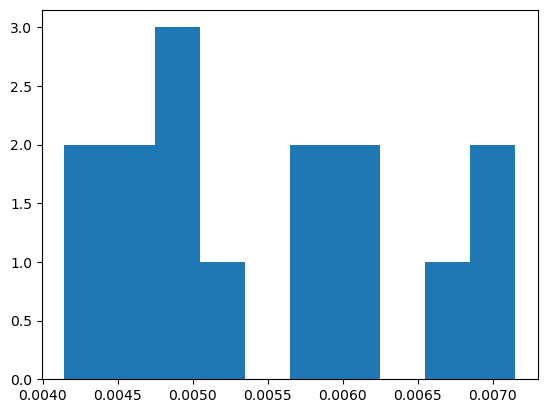

In [16]:
plt.hist(daily_c.leads/daily_c.session_id)
# failed - not normally distributed

In [17]:
cvr_c = control.leads.sum()/control.session_id.count()
cvr_v = variant.leads.sum()/variant.session_id.count()
uplift_ = (cvr_v-cvr_c)/cvr_c
print(uplift_)


-0.07047909235178484


# IF USING MAN-WHITNEY U TEST

((array([274.,  63.,  70.,   3.,   1.,   4.,   0.,   1.,   0.,   0.,   0.,
           0.,   0.,   0.,   1.]),
  array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16.]),
  <BarContainer object of 15 artists>),
 (array([239.,  55.,  45.,  10.,   5.,   3.,   2.,   0.,   0.,   0.,   1.]),
  array([ 1.        ,  1.90909091,  2.81818182,  3.72727273,  4.63636364,
          5.54545455,  6.45454545,  7.36363636,  8.27272727,  9.18181818,
         10.09090909, 11.        ]),
  <BarContainer object of 11 artists>))

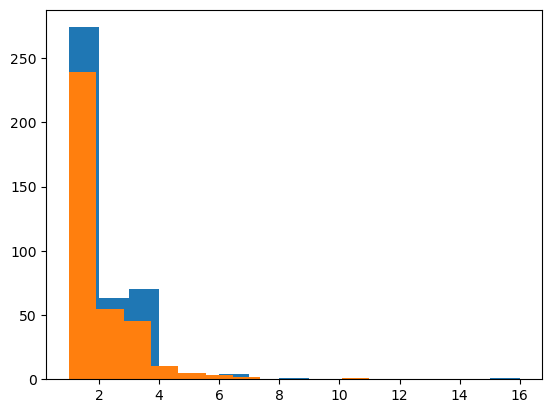

In [30]:
plt.hist(control.leads,bins=15), plt.hist(variant.leads.dropna(),bins=11)

In [35]:
stats.mannwhitneyu(control.leads.fillna(0),
                   variant.leads.fillna(0),
                   alternative='two-sided')


MannwhitneyuResult(statistic=7290310037.0, pvalue=0.2158456198130847)

In [33]:
import os 

os.environ['HOME']

'/Users/datnguyen'

In [4]:
os.environ['HOME']

'/Users/datnguyen'